In [101]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv
from imblearn import over_sampling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn import over_sampling  
import numpy as np
import re
import os
import datetime as dt
import pickle
from datetime import datetime
from scipy import stats
import random
from sklearn.model_selection import KFold
from IPython.display import display, Markdown
import pickle
from pandas import Series
from collections import defaultdict
import math
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import f1_score, auc, accuracy_score, recall_score, precision_score,\
confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [103]:
train=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_training_set.csv',skiprows=range(0,20))


In [104]:
test= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_test_set.csv',skiprows=range(0,20))

In [9]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [105]:
train.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [106]:
test.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [90]:
train.columns.shape

(171,)

In [107]:
train.dropna(axis=1, thresh=train.shape[0]*0.7, inplace=True)

In [92]:
train.columns.shape

(161,)

In [93]:
test.columns.shape

(171,)

In [108]:
test.dropna(axis=1, thresh=test.shape[0]*0.7, inplace=True)

In [95]:
test.columns.shape

(161,)

In [119]:
y_test=test['class']
y_train=train['class']

In [97]:
train.drop(columns=['class'],inplace=True)
test.drop(columns=['class'],inplace=True)

In [110]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_features = pd.DataFrame(scaler.transform(train), columns=train.columns)
test_features = pd.DataFrame(scaler.transform(test), columns=test.columns)

ValueError: could not convert string to float: 'neg'

In [113]:
#Impute median values of column to missing in the column 
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 2)
train_median_imputed = pd.DataFrame(impute_median.fit_transform(train),columns=train.columns)
test_median_imputed = pd.DataFrame(impute_median.transform(test),columns=test.columns)

In [78]:
#Dimensionality Reduction - using Principal Component Analysis
pca = PCA(0.99) #Define how much variance to explain
pca.fit(train_median_imputed)
best_train_features = pca.transform(train_median_imputed)
best_train_features = pd.DataFrame(best_train_features)
best_test_features = pd.DataFrame(pca.transform(test_median_imputed))

In [67]:
pca.explained_variance_ratio_[:99].sum()

0.9900869901884582

In [73]:
print(f'Number of components {pca.n_components_}')

Number of components 49


In [74]:
best_train_features

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.355140,0.798910,0.120648,-0.049208,0.000452,-0.050267,-0.022237,0.035347,-0.037167,-0.038075,...,0.002275,0.020856,-0.003726,0.001566,-0.000274,0.004721,-0.002124,0.003673,-0.011311,0.001757
1,0.160828,-0.155515,-0.157159,0.683948,0.031814,0.056123,-0.019407,0.017964,-0.033843,0.002684,...,0.001193,0.000056,-0.000112,-0.001539,-0.000066,-0.001190,0.000562,-0.002588,-0.000576,-0.000109
2,-0.209456,-0.132490,-0.017636,0.000709,-0.002027,-0.015970,0.002707,-0.018347,0.016069,-0.005062,...,-0.000057,-0.002798,0.002014,0.000194,-0.001933,0.001361,0.000404,-0.001085,0.001530,-0.000549
3,-0.470749,-0.099167,-0.042105,-0.003382,0.002841,0.006489,-0.001579,0.001946,-0.001655,0.005851,...,0.000281,0.001358,0.001103,-0.000306,0.000537,-0.000692,-0.000226,0.001902,-0.000622,-0.002460
4,0.275400,-0.187207,-0.057750,-0.013029,-0.010997,-0.017924,-0.009987,0.027938,-0.054380,-0.024117,...,-0.004922,-0.005555,-0.003790,-0.000218,-0.000348,0.001469,0.000764,0.003183,-0.003416,-0.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.859762,-0.262376,-0.000611,-0.001195,0.013922,-0.061114,-0.030832,-0.005164,-0.040744,0.010784,...,0.002706,0.004962,0.001066,0.002929,-0.004806,0.009738,0.006976,-0.004333,0.005625,-0.002571
59996,-0.207734,0.873937,0.027891,-0.013474,0.004093,0.017648,0.001854,-0.001565,0.002616,0.012014,...,0.000405,-0.001188,-0.000903,0.000232,-0.000964,-0.001745,-0.001248,0.000047,0.000620,0.000106
59997,-0.327323,0.886171,0.049480,-0.015976,0.003689,0.016545,0.001118,0.002791,-0.002684,0.010016,...,0.000445,-0.000948,-0.000725,0.000341,-0.001285,-0.001580,-0.001313,0.000176,0.000135,0.000257
59998,-0.258202,0.861894,0.235349,-0.026041,0.009981,-0.070788,-0.037472,0.017951,0.014893,-0.031167,...,-0.011240,-0.010445,-0.004723,-0.000347,-0.006168,0.008305,0.010269,0.006850,-0.000999,0.000909


In [80]:
from sklearn.preprocessing import LabelEncoder

In [111]:
le = LabelEncoder()
train['class'] = le.fit_transform(train['class'])
test['class'] = le.fit_transform(test['class'])

In [114]:
#Undersampling the negative class
train_neg_sampled = train_median_imputed[train_median_imputed['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train_median_imputed[train_median_imputed['class'] == 1].append(train_neg_sampled)

In [115]:
train_Sampled

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
9,1.0,153204.0,1.820000e+02,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
23,1.0,453236.0,2.926000e+03,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
60,1.0,72504.0,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
115,1.0,762958.0,1.520000e+02,126.0,0.0,0.0,776.0,281128.0,2186308.0,8123016.0,...,233796.0,112086.0,221518.0,189988.0,92432.0,41098.0,3812.0,0.0,0.0,0.0
135,1.0,695994.0,1.520000e+02,126.0,0.0,0.0,0.0,0.0,0.0,55620.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56472,0.0,38300.0,5.880000e+02,550.0,0.0,0.0,0.0,0.0,0.0,0.0,...,295836.0,134706.0,252728.0,278584.0,194686.0,169626.0,282316.0,20252.0,0.0,0.0
24100,0.0,47980.0,7.000000e+01,66.0,0.0,0.0,0.0,0.0,0.0,0.0,...,365386.0,210418.0,521896.0,518492.0,298242.0,153558.0,129412.0,290.0,0.0,0.0
22879,0.0,42002.0,1.196000e+03,126.0,0.0,0.0,0.0,0.0,0.0,0.0,...,502164.0,226528.0,431696.0,314668.0,221120.0,118500.0,98848.0,842.0,0.0,0.0
52139,0.0,7212.0,2.130706e+09,94.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70746.0,31240.0,62238.0,52312.0,52300.0,31562.0,27214.0,542.0,0.0,0.0


In [121]:
# Upsampling the positive class using Smote Technique
sm = over_sampling.SMOTE()
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,train_Sampled['class'])

In [123]:
train_Sampled_Smote

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,1.0,1.532040e+05,182.000000,126.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,1.180400e+04,...,1.298620e+05,2.687200e+04,3.404400e+04,2.247200e+04,3.436200e+04,0.000000e+00,0.000000e+00,0.000000,0.0,0.0
1,1.0,4.532360e+05,2926.000000,126.000000,0.0,0.0,0.000000,0.000000,2.220000e+02,3.234360e+05,...,7.908038e+06,3.026002e+06,5.025350e+06,2.025766e+06,1.160638e+06,5.338340e+05,4.938000e+05,6914.000000,0.0,0.0
2,1.0,7.250400e+04,1594.000000,1052.000000,0.0,0.0,0.000000,244.000000,1.782260e+05,1.249396e+06,...,1.432098e+06,3.722520e+05,5.275140e+05,3.582740e+05,3.328180e+05,2.841780e+05,3.742000e+03,0.000000,0.0,0.0
3,1.0,7.629580e+05,152.000000,126.000000,0.0,0.0,776.000000,281128.000000,2.186308e+06,8.123016e+06,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000,0.0,0.0
4,1.0,6.959940e+05,152.000000,126.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,5.562000e+04,...,1.397742e+06,4.955440e+05,3.616460e+05,2.861000e+04,5.130000e+03,2.120000e+02,0.000000e+00,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,4.216817e+05,68.921382,126.000000,0.0,0.0,0.000000,0.000000,6.718928e+04,7.784186e+05,...,5.944449e+05,2.303607e+05,5.411900e+05,1.152644e+06,1.239069e+06,2.950390e+05,4.475638e+04,0.000000,0.0,0.0
19996,1.0,2.183340e+05,136.247143,94.641300,0.0,0.0,0.000000,0.000000,0.000000e+00,8.769917e+03,...,9.945691e+04,2.146597e+04,2.881995e+04,1.994428e+04,3.043137e+04,1.160683e+04,2.642356e+02,0.000000,0.0,0.0
19997,1.0,8.824776e+05,1549.888772,126.000000,0.0,0.0,0.000000,19900.484878,4.598104e+05,5.494610e+06,...,3.665731e+06,1.670653e+06,4.848272e+06,1.642378e+07,1.038693e+07,2.073898e+06,9.506642e+04,24.262422,0.0,0.0
19998,1.0,2.315585e+05,296.774336,157.544867,0.0,0.0,0.000000,0.000000,2.453553e+03,1.282636e+05,...,2.650040e+06,8.207976e+05,6.209189e+05,1.672953e+05,5.924888e+04,1.844418e+04,1.284321e+03,0.000000,0.0,0.0


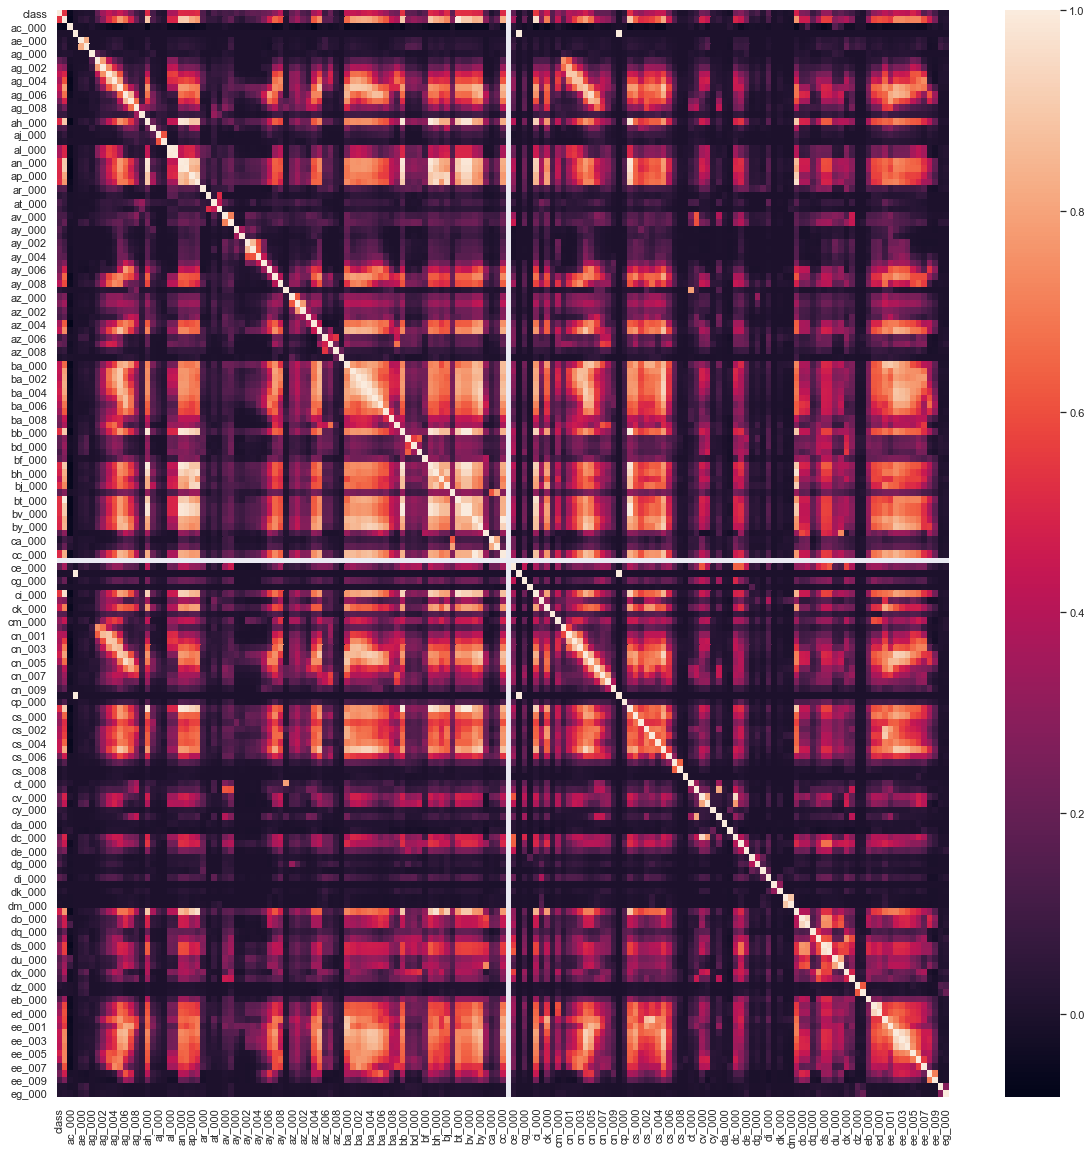

In [125]:
import seaborn as sns
#Plotting heat map for feature correlation from correlation matrix
corr_matrix = train_median_imputed.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_matrix, annot=False)
plt.show()

In [130]:
#Setting correlation coefficient threshold as 0.8 to remove highly correlated features in train data
#Reference: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.8)]
train_imp_features = train_median_imputed.drop(train_median_imputed[to_drop], axis=1)
train_imp_features.head()

,class,ac_000,af_000,ag_000,ag_001,ag_008,ag_009,ai_000,aj_000,ak_000,...,ee_000,ee_001,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,2.130706e+09,0.0,0.0,0.0,25896.0,0.0,0.0,0.0,0.0,...,965866.0,1706908.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,0.000000e+00,0.0,0.0,0.0,31642.0,0.0,0.0,68.0,0.0,...,664504.0,824154.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,2.280000e+02,0.0,0.0,0.0,12016.0,0.0,0.0,0.0,0.0,...,262032.0,453378.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,7.000000e+01,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5670.0,1566.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,1.368000e+03,0.0,0.0,0.0,4588.0,0.0,0.0,226.0,0.0,...,404740.0,904230.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [132]:
from sklearn.decomposition import PCA   

In [155]:
#Performing standardization and PCA for dimensionality reduction
start = datetime.now()
std = StandardScaler()
train_std = std.fit_transform(train_median_imputed)
train_pca = PCA(n_components= 160,random_state=42)
print(train_pca.fit_transform(train_std))
print("Time required to run this cell", datetime.now() - start)

[[ 2.34800186e+00 -1.18956027e+00  1.92224300e+00 ... -2.86050498e-05
   2.00276003e-07  2.68165883e-07]
 [-6.33352531e-01 -5.56637971e-01  8.98226776e-02 ...  2.84310090e-06
   2.87423752e-07 -1.91222570e-08]
 [-1.21190519e+00 -1.08143207e-01 -2.67121691e-01 ... -1.72200753e-06
  -4.35099564e-08 -4.31000296e-08]
 ...
 [-3.20430215e+00  1.41068151e-01 -7.69377728e-01 ...  2.90954720e-07
  -2.40776361e-08  2.45342188e-09]
 [ 2.35894571e+00 -2.57967037e+00  2.15473960e+00 ...  1.58647954e-05
  -5.19227737e-07  1.79457248e-07]
 [-7.36372968e-01 -4.40185390e-01  2.96364272e-01 ... -2.74096148e-06
  -5.42538458e-08  2.16935957e-08]]
Time required to run this cell 0:00:02.264574


<function matplotlib.pyplot.show(*args, **kw)>

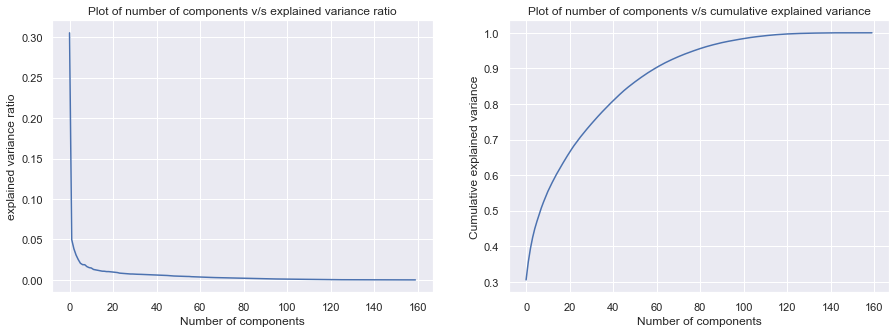

In [134]:
# Plot of number of features v/s explained variance ratio.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=train_pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("explained variance ratio")
plt.title("Plot of number of components v/s explained variance ratio")
plt.subplot(1,2,2)
sns.lineplot(data=np.cumsum(train_pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Plot of number of components v/s cumulative explained variance")
plt.show

In [153]:
train_pca

PCA(n_components=160, random_state=42)

In [152]:
dict={} #selecting 90 features as they are  explaining 97% of data
for i in range(1,161):
    dict[f'{i} features']=train_pca.explained_variance_ratio_[:i].sum()

In [150]:
dict

{'1 features': 0.30536152985680326,
 '2 features': 0.3552121685475766,
 '3 features': 0.3936588191920717,
 '4 features': 0.4243689910755228,
 '5 features': 0.4494860619987978,
 '6 features': 0.4700587519115812,
 '7 features': 0.48889789724332705,
 '8 features': 0.5076485084756724,
 '9 features': 0.5240513684401329,
 '10 features': 0.5392244325982687,
 '11 features': 0.5539261406264544,
 '12 features': 0.5668465593946636,
 '13 features': 0.5792165290384902,
 '14 features': 0.5911536301892247,
 '15 features': 0.6025436678143429,
 '16 features': 0.6133278438067843,
 '17 features': 0.6240195221717237,
 '18 features': 0.6342967173357026,
 '19 features': 0.6445555841568612,
 '20 features': 0.6544543338443104,
 '21 features': 0.6641282802670267,
 '22 features': 0.6735638639015296,
 '23 features': 0.6826349365627224,
 '24 features': 0.6910086849794261,
 '25 features': 0.699173584599904,
 '26 features': 0.7072370085020873,
 '27 features': 0.7148904724782074,
 '28 features': 0.7224207568271646,


In [142]:
train_pca.explained_variance_ratio_[:90].sum()

0.9709175691870275

In [157]:
type(y_train)

pandas.core.series.Series